# American Express - Default Prediction
- 카드사 고객의 채무 불이행 여부 예측

## Data
- Features
  - D_* = 연체 변수 (96개)
  - S_* = 소비 변수 (22개)
  - P_* = 지불 변수 (3개)
  - B_* = 균형 변수 (40개)
  - R_* = 위험 변수 (28개)
  - Customer_ID 포함 총 190개
<br>
- 데이터 크기 
  - train : 5,531,451  - 고객에게 주어진 명세서 수와 같음
  - test : 11,363,762
- target
  - 총 458,913개(명) - 고객 수와 같음, 고객의 채무 불이행 여부
  - 1 (채무 불이행) : 118,828개
  - 0 (채무 정상 이행) : 340,085개
    - 실제 American Express 데이터는 690만 고객 중 10만 명만이 채무 불이행 고객일 정도로 불균형한 데이터이다. 여기서는 모델링을 쉽게 하기 위해 데이터를 균형있게 제공해준 것.
    - 그렇기 때문에 평가지표 계산 시에는 target이 0인 데이터는 20배의 가중치를 받는다.
  - 여기서 target은 고객이 최근 명세서 날짜 이후 120일 이내에 만기 금액을 지불하지 않았을 때 채무 불이행이라고 분류가 됨.
<br>
- 아래 feature들은 범주형 데이터이고, 그 이외는 수치형 데이터
  - ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
<br>
- 기간
  - train : 2017-03-01 ~ 2018-03-31 (396일)
  - test : 2018-04-01 ~ 2019-10-31 (579일)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime, timedelta
import plotly.graph_objects as go
import missingno as msno
import warnings


## 설정

In [2]:
## 모든 열을 출력한다.
pd.set_option('display.max_columns', None) 
## warning 무시
warnings.filterwarnings(action='ignore')

In [3]:
DATA_DIR = './data'

## Load pickle

In [4]:
# load pickle

with open("./pickles/df_train.pickle", "rb") as fr:
    df_train = pickle.load(fr)
with open("./pickles/df_test.pickle", "rb") as fr:
    df_test = pickle.load(fr)
with open("./pickles/df_train_target.pickle", "rb") as fr:
    df_train_target = pickle.load(fr)

- target value

In [5]:
target1 = len(df_train_target[df_train_target["target"] == 1])
target0 = len(df_train_target[df_train_target["target"] == 0])

print(f"1 (채무 불이행) : {target1}")
print(f"0 (채무 정상 이행) : {target0}")

1 (채무 불이행) : 118828
0 (채무 정상 이행) : 340085


In [6]:
target=df_train_target.target.value_counts(normalize=True)
target.rename(index={1:'Default',0:'Paid'},inplace=True)
colors = ['#17becf', '#E1396C']
data = go.Pie(
values= target,
labels= target.index,
marker=dict(colors=colors),
textinfo='label+percent'
)
layout = go.Layout( 
title=dict(text = "Target Distribution",x=0.46,y=0.95,font_size=20)
)
fig = go.Figure(data=data,layout=layout)
fig.show()

- df_train

In [7]:
df_train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,NaN,NaN,0.000630,0.080986,0.708906,0.170600,0.006204,0.358587,0.525351,0.255736,NaN,0.063902,0.059416,0.006466,0.148698,1.335856,0.008207,0.001423,0.207334,0.736463,0.096219,NaN,0.023381,0.002768,0.008322,1.001519,0.008298,0.161345,0.148266,0.922998,0.354596,0.152025,0.118075,0.001882,0.158612,0.065728,0.018385,0.063646,0.199617,0.308233,0.016361,0.401619,0.091071,CR,O,0.007126,0.007665,NaN,0.652984,0.008520,NaN,0.004730,6.0,0.272008,0.008363,0.515222,0.002644,0.009013,0.004808,0.008342,0.119403,0.004802,0.108271,0.050882,NaN,0.007554,0.080422,0.069067,NaN,0.004327,0.007562,NaN,0.007729,0.000272,0.001576,0.004239,0.001434,NaN,0.002271,0.004061,0.007121,0.002456,0.002310,0.003532,0.506612,0.008033,1.009825,0.084683,0.003820,0.007043,0.000438,0.006452,0.000830,0.005055,NaN,0.0,0.005720,0.007084,NaN,0.000198,0.008907,NaN,1,0.002537,0.005177,0.006626,0.009705,0.007782,0.002450,1.001101,0.002665,0.007479,0.006893,1.503673,1.006133,0.003569,0.008871,0.003950,0.003647,0.004950,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1.008691,1.004587,0.893734,NaN,0.670041,0.009968,0.004572,NaN,1.008949,2.0,NaN,0.004326,NaN,NaN,NaN,1.007336,0.210060,0.676922,0.007871,1.0,0.238250,0.0,4.0,0.232120,0.236266,0.0,0.702280,0.434345,0.003057,0.686516,0.008740,1.0,1.003319,1.007819,1.000080,0.006805,NaN,0.002052,0.005972,NaN,0.004345,0.001535,NaN,NaN,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,NaN,NaN,0.002526,0.069419,0.712795,0.113239,0.006206,0.353630,0.521311,0.223329,NaN,0.065261,0.057744,0.001614,0.149723,1.339794,0.008373,0.001984,0.202778,0.720886,0.099804,NaN,0.030599,0.002749,0.002482,1.009033,0.005136,0.140951,0.143530,0.919414,0.326757,0.156201,0.118737,0.001610,0.148459,0.093935,0.013035,0.065501,0.151387,0.265026,0.017688,0.406326,0.086805,CR,O,0.002413,0.007148,NaN,0.647093,0.002238,NaN,0.003879,6.0,0.188970,0.004030,0.509048,0.004193,0.007842,0.001283,0.006524,0.140611,0.000094,0.101018,0.040469,NaN,0.004832,0.081413,0.074166,NaN,0.004203,0.005304,NaN,0.001864,0.000979,0.009896,0.007597,0.000509,NaN,0.009810,0.000127,0.005966,0.000395,0.001327,0.007773,0.500855,0.000760,1.009461,0.081843,0.000347,0.007789,0.004311,0.002332,0.009469,0.003753,NaN,0.0,0.007584,0.006677,NaN,0.001142,0.005907,NaN,1,0.008427,0.008979,0.001854,0.009924,0.005987,0.002247,1.006779,0.002508,0.006827,0.002837,1.503577,1.005791,0.000571,0.000391,0.008351,0.008850,0.003180,0.902135,0.136333,0.919876,0.975624,0.004561,0.786007,1.000084,1.004118,0.906841,NaN,0.668647,0.003921,0.004654,NaN,1.003205,2.0,NaN,0.008707,NaN,NaN,NaN,1.007653,0.184093,0.822281,0.003444,1.0,0.247217,0.0,4.0,0.243532,0.241885,0.0,0.707017,0.430501,0.001306,0.686414,0.000755,1.0,1.008394,1.004333,1.008344,0.004407,NaN,0.001034,0.004838,NaN,0.

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: float64(185), int64(1), object(4)
memory usage: 7.8+ GB


- categorical features

In [7]:
categorical = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
for feature in categorical:
  print(f"{feature} : {df_train[feature].unique()}")

B_30 : [ 0.  2.  1. nan]
B_38 : [ 2.  1.  3.  5.  6.  7.  4. nan]
D_114 : [ 1.  0. nan]
D_116 : [ 0. nan  1.]
D_117 : [ 4. -1.  6.  2.  1. nan  3.  5.]
D_120 : [ 0.  1. nan]
D_126 : [ 1. nan  0. -1.]
D_63 : ['CR' 'CO' 'CL' 'XZ' 'XM' 'XL']
D_64 : ['O' 'R' nan 'U' '-1']
D_66 : [nan  1.  0.]
D_68 : [ 6.  2.  3. nan  5.  4.  0.  1.]


- 고객별 가장 최근 명세서에 대한 정보만 추림

In [8]:
df_train = pd.DataFrame(df_train.groupby(['customer_ID']).tail(1))
df_test = pd.DataFrame(df_test.groupby(['customer_ID']).tail(1))

In [9]:
df_train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
12,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934745,0.009119,0.009382,1.007647,0.006104,0.135021,0.001604,0.007174,NaN,NaN,0.003258,0.070793,0.740102,0.231717,0.008309,0.420521,0.539715,0.192376,NaN,0.149564,0.058425,0.002927,0.153461,0.673522,0.009535,0.000085,0.203524,0.629392,0.326101,NaN,0.034643,0.010260,0.001770,1.008097,0.008517,0.105671,0.112294,0.488232,0.187285,0.166636,0.100107,0.009444,0.007174,0.007397,0.010239,0.063465,0.258461,0.227637,0.014553,0.402246,0.446568,CR,O,0.008656,0.006408,NaN,1.007897,0.005274,NaN,0.007630,6.0,0.184036,0.003945,0.686719,0.005375,0.005469,0.008050,0.008254,0.377991,0.006970,0.304625,0.040367,NaN,0.006564,0.001298,0.001352,NaN,0.002230,0.009162,0.421334,0.006475,0.001068,0.000747,0.002193,0.006345,NaN,0.000026,0.208253,0.001057,0.009351,0.007236,0.009177,0.507423,0.006550,1.002178,0.084745,0.006099,0.000013,0.002902,0.001115,0.001911,0.003256,NaN,0.0,0.001277,0.009968,NaN,0.002330,0.002517,NaN,1,0.003511,0.008099,0.007645,0.009411,0.006355,0.008501,1.007528,0.004638,0.001445,0.003080,1.006011,0.003641,0.004638,0.003866,0.005909,0.005458,0.001190,0.917811,0.131801,0.936067,0.971994,0.001281,0.943340,1.002457,1.014510,1.073985,NaN,0.671683,0.007441,0.008676,NaN,1.006130,2.0,NaN,0.000226,NaN,NaN,NaN,1.009372,0.100454,0.928955,0.003658,1.0,0.255787,0.0,4.0,0.260255,0.256656,0.0,0.719791,0.433844,0.003580,0.684978,0.008398,1.0,1.008338,0.999737,1.008523,0.003973,NaN,0.004186,0.005702,NaN,0.006210,0.002715,NaN,NaN,NaN,NaN,NaN,0.007186,0.004234,0.005086,NaN,0.005810,0.002970,0.008533
25,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,0.880519,0.178126,0.034684,1.004028,0.006911,0.165509,0.005552,0.005068,NaN,0.060646,0.008781,0.020626,0.266275,0.027000,0.004976,0.438828,0.402195,0.014696,NaN,0.167634,0.028411,0.000974,NaN,0.339683,0.012926,0.102036,0.242366,0.570898,0.297130,NaN,0.043929,0.014570,0.002911,1.002821,0.003283,0.208516,0.019050,0.406434,0.036112,0.748383,0.017684,0.005880,0.009756,0.127805,0.018667,0.212538,0.411989,0.048978,0.009538,0.363754,0.233980,CO,O,0.008747,0.002940,NaN,1.003602,0.008047,NaN,0.004319,6.0,0.192371,0.007744,0.287101,0.006190,0.007636,0.006174,0.000883,0.007636,0.001278,0.304711,0.014705,NaN,0.004659,0.007925,0.009600,NaN,0.002383,0.008256,0.227755,0.021153,0.000182,0.001542,0.009117,0.006892,NaN,0.006931,0.002119,0.002046,0.009664,0.005375,0.005009,NaN,0.005414,1.008568,0.019672,0.006197,0.005370,0.006271,0.009911,0.000983,0.006669,NaN,0.0,0.009298,0.006460,NaN,0.006503,0.007052,NaN,1,0.005091,0.001838,0.008645,0.009467,0.003500,0.000473,1.000766,0.004864,0.000907,0.003830,0.009166,0.004641,0.000195,0.000523,0.006421,0.004975,0.002397,0.920889,0.132865,0.930629,0.977674,0.003213,0.001621,0.008952,0.004363,NaN,NaN,0.007774,0.007457,0.032899,NaN,1.007599,2.0,NaN,0.004743,NaN,NaN,NaN,1.006547,0.019811,0.292214,0.009312,1.0,0.454329,0.0,-1.0,0.446036,0.436884,0.0,0.551341,0.286821,0.008603,0.136650,0.009314,1.0,0.000229,0.999252,0.001777,0.002943,NaN,0.002202,0.001928,NaN

---
# 여기서부터 작성
---

In [10]:
df_train_length = len(df_train) # 458913
df_test_length = len(df_test) # 924621

In [11]:
df_all = pd.concat([df_train, df_test], axis = 0).reset_index(drop = True)

In [12]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383534 entries, 0 to 1383533
Columns: 190 entries, customer_ID to D_145
dtypes: float64(185), int64(1), object(4)
memory usage: 2.0+ GB


- category 타입 변환

In [13]:
categorical = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
for feature in categorical:
  print(f"{feature} : {df_train[feature].unique()}")

B_30 : [ 0.  1.  2. nan]
B_38 : [ 2.  1.  3.  7.  5.  6.  4. nan]
D_114 : [ 1.  0. nan]
D_116 : [ 0. nan  1.]
D_117 : [ 4. -1.  6.  1.  2.  5.  3. nan]
D_120 : [ 0.  1. nan]
D_126 : [1. 0.]
D_63 : ['CR' 'CO' 'CL' 'XL' 'XZ' 'XM']
D_64 : ['O' 'R' 'U' nan]
D_66 : [nan  1.]
D_68 : [ 6.  3.  5.  4.  2.  1. nan]


In [14]:
df_all[categorical] = df_all.loc[:, categorical].astype('category')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383534 entries, 0 to 1383533
Columns: 190 entries, customer_ID to D_145
dtypes: category(11), float64(176), int64(1), object(2)
memory usage: 1.9+ GB


- CustomerID, S_2 삭제
  - 학습과 관련없는 column (고객 정보)

In [15]:
# customer_ID 저장
customerID = df_all['customer_ID']
customerID

0          0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...
1          00000fd6641609c6ece5454664794f0340ad84dddce9a2...
2          00001b22f846c82c51f6e3958ccd81970162bae8b007e8...
3          000041bdba6ecadd89a52d11886e8eaaec9325906c9723...
4          00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...
                                 ...                        
1383529    ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...
1383530    ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...
1383531    ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...
1383532    ffffddef1fc3643ea179c93245b68dca0f36941cd83977...
1383533    fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...
Name: customer_ID, Length: 1383534, dtype: object

In [16]:
df_all = df_all.iloc[:, 2:]
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383534 entries, 0 to 1383533
Columns: 188 entries, P_2 to D_145
dtypes: category(11), float64(176), int64(1)
memory usage: 1.8 GB


<AxesSubplot:>

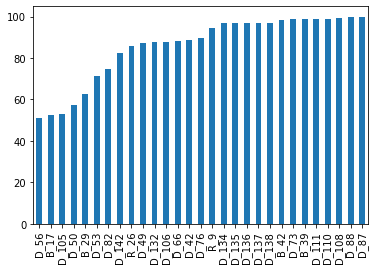

In [18]:
# train, test 병합 후 결측치 50% 이상인 컬럼
all_feat_null = df_all.isnull().sum() / len(df_all) * 100
all_feat_null[all_feat_null.values > 50].sort_values().plot.bar()

 - 70% 이상 결측치인 column은 drop

In [19]:
dropping_columns = all_feat_null[all_feat_null.values > 70].index.values
df_all = df_all.drop(dropping_columns, axis = 1)

In [20]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383534 entries, 0 to 1383533
Columns: 164 entries, P_2 to D_145
dtypes: category(10), float64(153), int64(1)
memory usage: 1.6 GB


- 결측치 확인

In [21]:
all_feat_null = df_all.isnull().sum() / len(df_all) * 100
all_feat_null = all_feat_null[all_feat_null != 0]
all_feat_null = all_feat_null.sort_values(ascending = False)
all_feat_null

B_29     62.757836
D_50     57.252153
D_105    53.222328
B_17     52.510961
D_56     51.170192
           ...    
B_30      0.005349
B_33      0.005349
B_27      0.005349
B_38      0.005349
B_26      0.005349
Length: 92, dtype: float64

---
# train, test 분리 후 학습
---

# Modeling 관련 라이브러리

In [23]:
from itertools import product

# Model
import xgboost as xgb 

# Feature selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Validation 
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [25]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [26]:
def XGBoost_Randomize_CV(X,y, parameters):
    # Create Parameter Combination
    keys, values = zip(*parameters.items())
    result = [dict(zip(keys, p)) for p in product(*values)]
    
    best_score = -1
    best_parameter = {}
    
    # Train Test Split
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for i in result:
        XGB_Model = xgb.XGBClassifier(**i,
                                      early_stopping_rounds = 10,
                                      verbosity = 0,
                                      n_jobs = -1).fit(train_X, train_y, eval_set = [(test_X, test_y)], verbose=False)
        
        pred = XGB_Model.predict(test_X).round().astype(int)
        amex_actual = pd.DataFrame({'target':test_y}).reset_index(drop=True)
        amex_prediction = pd.DataFrame({'prediction':XGB_Model.predict_proba(test_X)[:, 1]}).reset_index(drop=True)
        score = amex_metric(amex_actual,amex_prediction)
        
        if score > best_score:
            best_score = score
            best_parameter = i
            best_model = XGB_Model
        
        print(f'{i}: {score}')
        
    print(f'Best Parameters - {best_parameter}: {best_score}')
    
    return best_model

# 1. XGBoost - 1
- onehot 없음, smote 없음, 결측치 채우기 없음

In [37]:
X = df_all[:df_train_length]
y = df_train_target["target"]

In [38]:
X

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,S_16,D_80,R_10,R_11,B_27,D_81,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,R_17,R_18,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_107,B_36,B_37,R_27,B_38,D_109,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145
0,0.934745,0.009119,0.009382,1.007647,0.006104,0.135021,0.001604,0.007174,NaN,0.003258,0.070793,0.740102,0.231717,0.008309,0.420521,0.539715,0.192376,0.149564,0.058425,0.002927,0.153461,0.673522,0.009535,0.000085,0.203524,0.629392,0.326101,0.034643,0.010260,0.001770,1.008097,0.008517,0.105671,0.112294,0.488232,0.187285,0.166636,0.100107,0.009444,0.007174,0.007397,0.010239,0.063465,0.258461,0.227637,0.014553,0.402246,0.446568,CR,O,0.008656,0.006408,NaN,1.007897,0.005274,0.007630,6.0,0.184036,0.003945,0.686719,0.005375,0.005469,0.008050,0.008254,0.377991,0.006970,0.304625,0.040367,0.006564,0.001298,0.001352,0.002230,0.009162,0.421334,0.006475,0.001068,0.000747,0.002193,0.006345,0.000026,0.208253,0.001057,0.009351,0.007236,0.009177,0.006550,1.002178,0.084745,0.006099,0.000013,0.002902,0.001115,0.001911,0.003256,NaN,0.0,0.001277,0.009968,0.002330,0.002517,1,0.003511,0.008099,0.007645,0.009411,0.006355,0.008501,1.007528,0.004638,0.001445,0.003080,1.006011,0.003641,0.004638,0.003866,0.005909,0.005458,0.001190,0.917811,0.131801,0.936067,0.971994,0.001281,0.943340,1.002457,1.014510,1.073985,0.671683,0.007441,0.008676,1.006130,2.0,0.000226,1.009372,0.100454,0.928955,0.003658,1.0,0.255787,0.0,4.0,0.260255,0.256656,0.0,0.719791,0.433844,0.003580,0.684978,0.008398,1.0,1.008338,0.999737,1.008523,0.003973,0.004186,0.005702,0.006210,0.002715,0.007186,0.004234,0.005086,0.005810,0.002970,0.008533
1,0.880519,0.178126,0.034684,1.004028,0.006911,0.165509,0.005552,0.005068,0.060646,0.008781,0.020626,0.266275,0.027000,0.004976,0.438828,0.402195,0.014696,0.167634,0.028411,0.000974,NaN,0.339683,0.012926,0.102036,0.242366,0.570898,0.297130,0.043929,0.014570,0.002911,1.002821,0.003283,0.208516,0.019050,0.406434,0.036112,0.748383,0.017684,0.005880,0.009756,0.127805,0.018667,0.212538,0.411989,0.048978,0.009538,0.363754,0.233980,CO,O,0.008747,0.002940,NaN,1.003602,0.008047,0.004319,6.0,0.192371,0.007744,0.287101,0.006190,0.007636,0.006174,0.000883,0.007636,0.001278,0.304711,0.014705,0.004659,0.007925,0.009600,0.002383,0.008256,0.227755,0.021153,0.000182,0.001542,0.009117,0.006892,0.006931,0.002119,0.002046,0.009664,0.005375,0.005009,0.005414,1.008568,0.019672,0.006197,0.005370,0.006271,0.009911,0.000983,0.006669,NaN,0.0,0.009298,0.006460,0.006503,0.007052,1,0.005091,0.001838,0.008645,0.009467,0.003500,0.000473,1.000766,0.004864,0.000907,0.003830,0.009166,0.004641,0.000195,0.000523,0.006421,0.004975,0.002397,0.920889,0.132865,0.930629,0.977674,0.003213,0.001621,0.008952,0.004363,NaN,0.007774,0.007457,0.032899,1.007599,2.0,0.004743,1.006547,0.019811,0.292214,0.009312,1.0,0.454329,0.0,-1.0,0.446036,0.436884,0.0,0.551341,0.286821,0.008603,0.136650,0.009314,1.0,0.000229,0.999252,0.001777,0.002943,0.002202,0.001928,0.002996,0.001701,0.002980,0.007479,0.007870,0.003284,0.003169,0.008514
2,0.880875,0.009704,0.004284,0.812650,0.006450,NaN,0.003796,0.007196,NaN,0.000628,0.031044,0.251598,0.001557,0.001687,0.433713,0.339125,0.080370,0.183628,0.026981,0.000247,NaN,0.342118,0.009392,0.006264,0.202159,0.628938,0.296313,0.001824,0.005092,1.002365,1.005992,0.001983,NaN,0.007158,0.009188,0.098963,0.209386,0.001749,0.003000,0.002847,NaN,0.006699,0.213039,0.0028

In [44]:
df_all

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,S_16,D_80,R_10,R_11,B_27,D_81,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,R_17,R_18,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_107,B_36,B_37,R_27,B_38,D_109,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145
0,0.934745,0.009119,0.009382,1.007647,0.006104,0.135021,0.001604,0.007174,NaN,0.003258,0.070793,0.740102,0.231717,0.008309,0.420521,0.539715,0.192376,0.149564,0.058425,0.002927,0.153461,0.673522,0.009535,0.000085,0.203524,0.629392,0.326101,0.034643,0.010260,0.001770,1.008097,0.008517,0.105671,0.112294,0.488232,0.187285,0.166636,0.100107,0.009444,0.007174,0.007397,0.010239,0.063465,0.258461,0.227637,0.014553,0.402246,0.446568,CR,O,0.008656,0.006408,NaN,1.007897,0.005274,0.007630,6.0,0.184036,0.003945,0.686719,0.005375,0.005469,0.008050,0.008254,0.377991,0.006970,0.304625,0.040367,0.006564,0.001298,0.001352,0.002230,0.009162,0.421334,0.006475,0.001068,0.000747,0.002193,0.006345,0.000026,0.208253,0.001057,0.009351,0.007236,0.009177,0.006550,1.002178,0.084745,0.006099,0.000013,0.002902,0.001115,0.001911,0.003256,NaN,0.0,0.001277,0.009968,0.002330,0.002517,1,0.003511,0.008099,0.007645,0.009411,0.006355,0.008501,1.007528,0.004638,0.001445,0.003080,1.006011,0.003641,0.004638,0.003866,0.005909,0.005458,0.001190,0.917811,0.131801,0.936067,0.971994,0.001281,0.943340,1.002457,1.014510,1.073985,0.671683,0.007441,0.008676,1.006130,2.0,0.000226,1.009372,0.100454,0.928955,0.003658,1.0,0.255787,0.0,4.0,0.260255,0.256656,0.0,0.719791,0.433844,0.003580,0.684978,0.008398,1.0,1.008338,0.999737,1.008523,0.003973,0.004186,0.005702,0.006210,0.002715,0.007186,0.004234,0.005086,0.005810,0.002970,0.008533
1,0.880519,0.178126,0.034684,1.004028,0.006911,0.165509,0.005552,0.005068,0.060646,0.008781,0.020626,0.266275,0.027000,0.004976,0.438828,0.402195,0.014696,0.167634,0.028411,0.000974,NaN,0.339683,0.012926,0.102036,0.242366,0.570898,0.297130,0.043929,0.014570,0.002911,1.002821,0.003283,0.208516,0.019050,0.406434,0.036112,0.748383,0.017684,0.005880,0.009756,0.127805,0.018667,0.212538,0.411989,0.048978,0.009538,0.363754,0.233980,CO,O,0.008747,0.002940,NaN,1.003602,0.008047,0.004319,6.0,0.192371,0.007744,0.287101,0.006190,0.007636,0.006174,0.000883,0.007636,0.001278,0.304711,0.014705,0.004659,0.007925,0.009600,0.002383,0.008256,0.227755,0.021153,0.000182,0.001542,0.009117,0.006892,0.006931,0.002119,0.002046,0.009664,0.005375,0.005009,0.005414,1.008568,0.019672,0.006197,0.005370,0.006271,0.009911,0.000983,0.006669,NaN,0.0,0.009298,0.006460,0.006503,0.007052,1,0.005091,0.001838,0.008645,0.009467,0.003500,0.000473,1.000766,0.004864,0.000907,0.003830,0.009166,0.004641,0.000195,0.000523,0.006421,0.004975,0.002397,0.920889,0.132865,0.930629,0.977674,0.003213,0.001621,0.008952,0.004363,NaN,0.007774,0.007457,0.032899,1.007599,2.0,0.004743,1.006547,0.019811,0.292214,0.009312,1.0,0.454329,0.0,-1.0,0.446036,0.436884,0.0,0.551341,0.286821,0.008603,0.136650,0.009314,1.0,0.000229,0.999252,0.001777,0.002943,0.002202,0.001928,0.002996,0.001701,0.002980,0.007479,0.007870,0.003284,0.003169,0.008514
2,0.880875,0.009704,0.004284,0.812650,0.006450,NaN,0.003796,0.007196,NaN,0.000628,0.031044,0.251598,0.001557,0.001687,0.433713,0.339125,0.080370,0.183628,0.026981,0.000247,NaN,0.342118,0.009392,0.006264,0.202159,0.628938,0.296313,0.001824,0.005092,1.002365,1.005992,0.001983,NaN,0.007158,0.009188,0.098963,0.209386,0.001749,0.003000,0.002847,NaN,0.006699,0.213039,0.0028

In [39]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458913 entries, 0 to 458912
Columns: 164 entries, P_2 to D_145
dtypes: category(10), float64(153), int64(1)
memory usage: 543.6 MB


In [40]:
# Train Test Split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

In [41]:
random_parameters = {'max_depth':[9,10,11,12],
                      'min_child_weight': [5,6,7,8],
                      'eta':[.1, .01, .001],
                      'objective':['binary:logistic'],
                      'tree_method': ['gpu_hist'],
                      'eval_metric': ['rmsle'],
                      'predictor': ['gpu_predictor']
}

XGB_Best = XGBoost_Randomize_CV(train_X,train_y, random_parameters)

{'max_depth': 9, 'min_child_weight': 5, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7638069823258702
{'max_depth': 9, 'min_child_weight': 5, 'eta': 0.01, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7562965804187952
{'max_depth': 9, 'min_child_weight': 5, 'eta': 0.001, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7327379960669427
{'max_depth': 9, 'min_child_weight': 6, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7687309449313934
{'max_depth': 9, 'min_child_weight': 6, 'eta': 0.01, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7542670130317026
{'max_depth': 9, 'min_child_weight': 6, 'eta': 0.001, 'objective': 'bin

In [42]:
# Validation
pred = XGB_Best.predict(test_X).round().astype(int)
amex_actual = pd.DataFrame({'target':test_y}).reset_index(drop=True)
amex_prediction = pd.DataFrame({'prediction':XGB_Best.predict_proba(test_X)[:, 1]}).reset_index(drop=True)

print('Accuracy:', accuracy_score(test_y, pred))
print('Log Loss:', log_loss(test_y, pred))
print('ROC Accuracy:', roc_auc_score(test_y, pred))
print('Confusion Matrix:\n', 
       confusion_matrix(test_y, pred))
print('Amex Metric:', amex_metric(amex_actual,amex_prediction))

Accuracy: 0.8959934337638189
Log Loss: 3.592299905577403
ROC Accuracy: 0.8621813453529186
Confusion Matrix:
 [[95234  6951]
 [ 7368 28121]]
Amex Metric: 0.7672884779364937


---
## 제출 : 1. XGBoost
---

In [94]:
test_X = df_all[df_train_length:]

In [96]:
XGB_pred = XGB_Best.predict(test_X)

In [97]:
len(XGB_pred)

924621

In [100]:
submission = pd.DataFrame(customerID)[df_train_length:]
submission

,customer_ID
458913,00000469ba478561f23a92a868bd366de6f6527a684c9a...
458914,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...
458915,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...
458916,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...
458917,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...
...,...
1383529,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...
1383530,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...
1383531,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...
1383532,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...


In [101]:
submission['prediction'] = XGB_pred

In [103]:
submission.to_csv('submission2.csv', index=False)

---

# 2. XGBoost
- 결측치 채우기 있음, onehot 있음

### 결측치 채우기
- 결측치 채울 때 서로 결측치간 상관성이 있는 피처는 선형회귀로 채우고 (MICE imputer 아니면 딴 거 찾아보기)
- 상관성이 별로 없는 피처는 평균으로 채우기 (simple imputer)
- 그렇게 다 채우고 나서 onehot
- **1번** 그러고 나서 한번 모델링 해보고 
- onehot 한 상태에서 피처들의 상관성을 보고 피처끼리 상관성이 큰 피처는 하나는 지우거나 합쳐서 새로운 피처 만들기
- **2번** 그렇게 하면 피처 수를 좀 줄일 수 있는데 그렇게 해서 모델링 해보기
- 그러고 나서 **1번**, **2번**에 대해서 skewness에 따라서 log transformation 하기 전 후 모델링 해보고 성능 달라지는 거 보기
---
- IterativeImputer를 써서 상관성이 있는 피처끼리 회귀로 채우려 했으나 너무 오래 걸려서 못 하고 다 평균으로 채움

In [29]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383534 entries, 0 to 1383533
Columns: 164 entries, P_2 to D_145
dtypes: category(10), float64(153), int64(1)
memory usage: 1.6 GB


In [30]:
all_feat_null = df_all.isnull().sum() / len(df_all) * 100
all_feat_null = all_feat_null[all_feat_null != 0]
all_feat_null = all_feat_null.sort_values(ascending = False)
all_feat_null

B_29     62.757836
D_50     57.252153
D_105    53.222328
B_17     52.510961
D_56     51.170192
           ...    
B_30      0.005349
B_33      0.005349
B_27      0.005349
B_38      0.005349
B_26      0.005349
Length: 92, dtype: float64

In [31]:
categorical.remove('D_66')

In [32]:
numeric = df_all.columns.drop(categorical)
numeric

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_43',
       'D_44',
       ...
       'D_130', 'D_131', 'D_133', 'R_28', 'D_139', 'D_140', 'D_141', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=154)

In [36]:
from sklearn.impute import SimpleImputer

# numeric 데이터 : 평균으로 채우기

simpleimputer_num = SimpleImputer(strategy="mean")

simpleimputer_num.fit(df_all[numeric])

df_numeric_X = simpleimputer_num.transform(df_all[numeric])
df_all_num_new = pd.DataFrame(df_numeric_X, columns = df_all[numeric].columns)
df_all_num_new

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_65,B_16,B_17,B_18,B_19,B_20,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,S_16,D_80,R_10,R_11,B_27,D_81,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,S_18,D_86,R_17,R_18,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_107,B_36,B_37,R_27,D_109,D_112,B_40,S_27,D_113,D_115,D_118,D_119,D_121,D_122,D_123,D_124,D_125,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145
0,0.934745,0.009119,0.009382,1.007647,0.006104,0.135021,0.001604,0.007174,0.164065,0.003258,0.070793,0.740102,0.231717,0.008309,0.420521,0.539715,0.192376,0.149564,0.058425,0.002927,0.153461,0.673522,0.009535,0.000085,0.203524,0.629392,0.326101,0.034643,0.010260,0.001770,1.008097,0.008517,0.105671,0.112294,0.488232,0.187285,0.166636,0.100107,0.009444,0.007174,0.007397,0.010239,0.063465,0.258461,0.227637,0.014553,0.402246,0.446568,0.008656,0.006408,0.727407,1.007897,0.005274,0.007630,0.184036,0.003945,0.686719,0.005375,0.005469,0.008050,0.008254,0.377991,0.006970,0.304625,0.040367,0.006564,0.001298,0.001352,0.002230,0.009162,0.421334,0.006475,0.001068,0.000747,0.002193,0.006345,0.000026,0.208253,0.001057,0.009351,0.007236,0.009177,0.006550,1.002178,0.084745,0.006099,0.000013,0.002902,0.001115,0.001911,0.003256,0.012080,0.001277,0.009968,0.002330,0.002517,1.0,0.003511,0.008099,0.007645,0.009411,0.006355,0.008501,1.007528,0.004638,0.001445,0.003080,1.006011,0.003641,0.004638,0.003866,0.005909,0.005458,0.001190,0.917811,0.131801,0.936067,0.971994,0.001281,0.943340,1.002457,1.014510,1.073985,0.671683,0.007441,0.008676,1.006130,0.000226,1.009372,0.100454,0.928955,0.003658,0.255787,0.260255,0.256656,0.719791,0.433844,0.003580,0.684978,0.008398,1.008338,0.999737,1.008523,0.003973,0.004186,0.005702,0.006210,0.002715,0.007186,0.004234,0.005086,0.005810,0.002970,0.008533
1,0.880519,0.178126,0.034684,1.004028,0.006911,0.165509,0.005552,0.005068,0.060646,0.008781,0.020626,0.266275,0.027000,0.004976,0.438828,0.402195,0.014696,0.167634,0.028411,0.000974,0.181947,0.339683,0.012926,0.102036,0.242366,0.570898,0.297130,0.043929,0.014570,0.002911,1.002821,0.003283,0.208516,0.019050,0.406434,0.036112,0.748383,0.017684,0.005880,0.009756,0.127805,0.018667,0.212538,0.411989,0.048978,0.009538,0.363754,0.233980,0.008747,0.002940,0.727407,1.003602,0.008047,0.004319,0.192371,0.007744,0.287101,0.006190,0.007636,0.006174,0.000883,0.007636,0.001278,0.304711,0.014705,0.004659,0.007925,0.009600,0.002383,0.008256,0.227755,0.021153,0.000182,0.001542,0.009117,0.006892,0.006931,0.002119,0.002046,0.009664,0.005375,0.005009,0.005414,1.008568,0.019672,0.006197,0.005370,0.006271,0.009911,0.000983,0.006669,0.012080,0.009298,0.006460,0.006503,0.007052,1.0,0.005091,0.001838,0.008645,0.009467,0.003500,0.000473,1.000766,0.004864,0.000907,0.003830,0.009166,0.004641,0.000195,0.000523,0.006421,0.004975,0.002397,0.920889,0.132865,0.930629,0.977674,0.003213,0.001621,0.008952,0.004363,0.387050,0.007774,0.007457,0.032899,1.007599,0.004743,1.006547,0.019811,0.292214,0.009312,0.454329,0.446036,0.436884,0.551341,0.286821,0.008603,0.136650,0.009314,0.000229,0.999252,0.001777,0.002943,0.002202,0.001928,0.002996,0.001701,0.002980,0.007479,0.007870,0.003284,0.003169,0.008514
2,0.880875,0.009704,0.004284,0.812650,0.006450,0.228753,0.003796,0.007196,0.164065,0.000628,0.031044,0.251598,0.001557,0.001687,0.433713,0.339125,0.080370,0.183628,0.026981,0.000247,0.181947,0.342118,0.009392,0.006264,0.202159,0.628938,0.296313,0.001824,0.005092,1.002365,1.005992,0.001983,0.215204,0.007158,0.009188,0.098963,0.209386,0.001749,0.003000,0.002847,0.052539,0.006699,0.213039,0.002820,0.137834,0.006031,0.280417,0.438647,0.000845,0.007836,0.727407,

In [ ]:
simpleimputer_cat = SimpleImputer(strategy="most_frequent")
simpleimputer_cat.fit(df_all[categorical])

df_categorical_X = simpleimputer_cat.transform(df_all[categorical])

In [37]:
# categorical 데이터 : 최빈값으로 채우기

simpleimputer_cat = SimpleImputer(strategy="most_frequent")

simpleimputer_cat.fit(df_all[categorical])

df_categorical_X = simpleimputer_cat.transform(df_all[categorical])
df_all_cat_new = pd.DataFrame(df_categorical_X, columns = df_all[categorical].columns)
df_all_cat_new

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_68
0,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0
1,0.0,2.0,1.0,0.0,-1.0,0.0,1.0,CO,O,6.0
2,0.0,1.0,1.0,0.0,-1.0,0.0,1.0,CO,R,6.0
3,0.0,2.0,1.0,0.0,6.0,0.0,1.0,CO,O,3.0
4,0.0,1.0,1.0,0.0,4.0,0.0,1.0,CO,O,6.0
...,...,...,...,...,...,...,...,...,...,...
1383529,0.0,1.0,1.0,0.0,3.0,0.0,1.0,CO,O,6.0
1383530,0.0,3.0,1.0,0.0,3.0,0.0,1.0,CO,O,6.0
1383531,0.0,3.0,1.0,0.0,3.0,0.0,1.0,CR,O,6.0
1383532,0.0,3.0,1.0,0.0,-1.0,1.0,1.0,CO,U,5.0


In [39]:
df_all_new = pd.concat([df_all_num_new, df_all_cat_new], axis = 1)
df_all_new

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_65,B_16,B_17,B_18,B_19,B_20,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,S_16,D_80,R_10,R_11,B_27,D_81,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,S_18,D_86,R_17,R_18,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_107,B_36,B_37,R_27,D_109,D_112,B_40,S_27,D_113,D_115,D_118,D_119,D_121,D_122,D_123,D_124,D_125,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_68
0,0.934745,0.009119,0.009382,1.007647,0.006104,0.135021,0.001604,0.007174,0.164065,0.003258,0.070793,0.740102,0.231717,0.008309,0.420521,0.539715,0.192376,0.149564,0.058425,0.002927,0.153461,0.673522,0.009535,0.000085,0.203524,0.629392,0.326101,0.034643,0.010260,0.001770,1.008097,0.008517,0.105671,0.112294,0.488232,0.187285,0.166636,0.100107,0.009444,0.007174,0.007397,0.010239,0.063465,0.258461,0.227637,0.014553,0.402246,0.446568,0.008656,0.006408,0.727407,1.007897,0.005274,0.007630,0.184036,0.003945,0.686719,0.005375,0.005469,0.008050,0.008254,0.377991,0.006970,0.304625,0.040367,0.006564,0.001298,0.001352,0.002230,0.009162,0.421334,0.006475,0.001068,0.000747,0.002193,0.006345,0.000026,0.208253,0.001057,0.009351,0.007236,0.009177,0.006550,1.002178,0.084745,0.006099,0.000013,0.002902,0.001115,0.001911,0.003256,0.012080,0.001277,0.009968,0.002330,0.002517,1.0,0.003511,0.008099,0.007645,0.009411,0.006355,0.008501,1.007528,0.004638,0.001445,0.003080,1.006011,0.003641,0.004638,0.003866,0.005909,0.005458,0.001190,0.917811,0.131801,0.936067,0.971994,0.001281,0.943340,1.002457,1.014510,1.073985,0.671683,0.007441,0.008676,1.006130,0.000226,1.009372,0.100454,0.928955,0.003658,0.255787,0.260255,0.256656,0.719791,0.433844,0.003580,0.684978,0.008398,1.008338,0.999737,1.008523,0.003973,0.004186,0.005702,0.006210,0.002715,0.007186,0.004234,0.005086,0.005810,0.002970,0.008533,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0
1,0.880519,0.178126,0.034684,1.004028,0.006911,0.165509,0.005552,0.005068,0.060646,0.008781,0.020626,0.266275,0.027000,0.004976,0.438828,0.402195,0.014696,0.167634,0.028411,0.000974,0.181947,0.339683,0.012926,0.102036,0.242366,0.570898,0.297130,0.043929,0.014570,0.002911,1.002821,0.003283,0.208516,0.019050,0.406434,0.036112,0.748383,0.017684,0.005880,0.009756,0.127805,0.018667,0.212538,0.411989,0.048978,0.009538,0.363754,0.233980,0.008747,0.002940,0.727407,1.003602,0.008047,0.004319,0.192371,0.007744,0.287101,0.006190,0.007636,0.006174,0.000883,0.007636,0.001278,0.304711,0.014705,0.004659,0.007925,0.009600,0.002383,0.008256,0.227755,0.021153,0.000182,0.001542,0.009117,0.006892,0.006931,0.002119,0.002046,0.009664,0.005375,0.005009,0.005414,1.008568,0.019672,0.006197,0.005370,0.006271,0.009911,0.000983,0.006669,0.012080,0.009298,0.006460,0.006503,0.007052,1.0,0.005091,0.001838,0.008645,0.009467,0.003500,0.000473,1.000766,0.004864,0.000907,0.003830,0.009166,0.004641,0.000195,0.000523,0.006421,0.004975,0.002397,0.920889,0.132865,0.930629,0.977674,0.003213,0.001621,0.008952,0.004363,0.387050,0.007774,0.007457,0.032899,1.007599,0.004743,1.006547,0.019811,0.292214,0.009312,0.454329,0.446036,0.436884,0.551341,0.286821,0.008603,0.136650,0.009314,0.000229,0.999252,0.001777,0.002943,0.002202,0.001928,0.002996,0.001701,0.002980,0.007479,0.007870,0.003284,0.003169,0.008514,0.0,2.0,1.0,0.0,-1.0,0.0,1.0,CO,O,6.0
2,0.880875,0.009704,0.004284,0.812650,0.006450,0.228753,0.003796,0.007196,0.164065,0.000628,0.031044,0.251598,0.001557,0.001687,0.433713,0.339125,0.080370,0.183628,0.026981,0.000247,0.181947,0.342118,0.009392,0.006264,0.202159,0.628938,0.296313,0.001824,0.005092,1.002365,1.005992,0.001983,0.215204,0.007158,0.009188,0.098963,0.209

### 아래 - IterativeImputer를 사용해서 결측치 채워보려 했으나 너무 시간이 오래 걸려서 못함

In [206]:
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)
imputer_mice = IterativeImputer(random_state=83, verbose=2, estimator=rfr)

In [ ]:
imputer_mice.fit_transform(df_all[numeric])

### onehot

In [42]:
df_all_new_onehot = pd.get_dummies(df_all_new)
df_all_new_onehot

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_65,B_16,B_17,B_18,B_19,B_20,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,S_16,D_80,R_10,R_11,B_27,D_81,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,S_18,D_86,R_17,R_18,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_107,B_36,B_37,R_27,D_109,D_112,B_40,S_27,D_113,D_115,D_118,D_119,D_121,D_122,D_123,D_124,D_125,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145,B_30_0.0,B_30_1.0,B_30_2.0,B_38_1.0,B_38_2.0,B_38_3.0,B_38_4.0,B_38_5.0,B_38_6.0,B_38_7.0,D_114_0.0,D_114_1.0,D_116_0.0,D_116_1.0,D_117_-1.0,D_117_1.0,D_117_2.0,D_117_3.0,D_117_4.0,D_117_5.0,D_117_6.0,D_120_0.0,D_120_1.0,D_126_0.0,D_126_1.0,D_63_CL,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_64_O,D_64_R,D_64_U,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0
0,0.934745,0.009119,0.009382,1.007647,0.006104,0.135021,0.001604,0.007174,0.164065,0.003258,0.070793,0.740102,0.231717,0.008309,0.420521,0.539715,0.192376,0.149564,0.058425,0.002927,0.153461,0.673522,0.009535,0.000085,0.203524,0.629392,0.326101,0.034643,0.010260,0.001770,1.008097,0.008517,0.105671,0.112294,0.488232,0.187285,0.166636,0.100107,0.009444,0.007174,0.007397,0.010239,0.063465,0.258461,0.227637,0.014553,0.402246,0.446568,0.008656,0.006408,0.727407,1.007897,0.005274,0.007630,0.184036,0.003945,0.686719,0.005375,0.005469,0.008050,0.008254,0.377991,0.006970,0.304625,0.040367,0.006564,0.001298,0.001352,0.002230,0.009162,0.421334,0.006475,0.001068,0.000747,0.002193,0.006345,0.000026,0.208253,0.001057,0.009351,0.007236,0.009177,0.006550,1.002178,0.084745,0.006099,0.000013,0.002902,0.001115,0.001911,0.003256,0.012080,0.001277,0.009968,0.002330,0.002517,1.0,0.003511,0.008099,0.007645,0.009411,0.006355,0.008501,1.007528,0.004638,0.001445,0.003080,1.006011,0.003641,0.004638,0.003866,0.005909,0.005458,0.001190,0.917811,0.131801,0.936067,0.971994,0.001281,0.943340,1.002457,1.014510,1.073985,0.671683,0.007441,0.008676,1.006130,0.000226,1.009372,0.100454,0.928955,0.003658,0.255787,0.260255,0.256656,0.719791,0.433844,0.003580,0.684978,0.008398,1.008338,0.999737,1.008523,0.003973,0.004186,0.005702,0.006210,0.002715,0.007186,0.004234,0.005086,0.005810,0.002970,0.008533,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
1,0.880519,0.178126,0.034684,1.004028,0.006911,0.165509,0.005552,0.005068,0.060646,0.008781,0.020626,0.266275,0.027000,0.004976,0.438828,0.402195,0.014696,0.167634,0.028411,0.000974,0.181947,0.339683,0.012926,0.102036,0.242366,0.570898,0.297130,0.043929,0.014570,0.002911,1.002821,0.003283,0.208516,0.019050,0.406434,0.036112,0.748383,0.017684,0.005880,0.009756,0.127805,0.018667,0.212538,0.411989,0.048978,0.009538,0.363754,0.233980,0.008747,0.002940,0.727407,1.003602,0.008047,0.004319,0.192371,0.007744,0.287101,0.006190,0.007636,0.006174,0.000883,0.007636,0.001278,0.304711,0.014705,0.004659,0.007925,0.009600,0.002383,0.008256,0.227755,0.021153,0.000182,0.001542,0.009117,0.006892,0.006931,0.002119,0.002046,0.009664,0.005375,0.005009,0.005414,1.008568,0.019672,0.006197,0.005370,0.006271,0.009911,0.000983,0.006669,0.012080,0.009298,0.006460,0.006503,0.007052,1.0,0.005091,0.001838,0.008645,0.009467,0.003500,0.000473,1.000766,0.004864,0.000907,0.003830,0.009166,0.004641,0.000195,0.000523,0.006421,0.004975,0.002397,0.920889,0.132865,0.930629,0.977674,0.003213,0.001621,0.008952,0.004363,0.387050,0.007774,0.007457,0.032899,1.007599,0.004743,1.006547,0.019811,0.292214,0.009312,0.454329,0.446036,0.436884,0.551341,0.286821,0.008603,0.136650,0.009314,0.000229,0.999252,0.001777,0.002943,0.002202,0.001928,0.002996,0.001701,0.002980,0.007479,0.007870,0.003284,0.003169,0.008514,1,0,0,0,1,0,0,0,0

In [44]:
X = df_all_new_onehot[:df_train_length]
y = df_train_target["target"]

# Train Test Split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

random_parameters = {'max_depth':[9,10,11],
                      'min_child_weight': [5,6,7,8],
                      'eta':[.1, .01, .001],
                      'objective':['binary:logistic'],
                      'tree_method': ['gpu_hist'],
                      'eval_metric': ['rmsle'],
                      'predictor': ['gpu_predictor']
}

XGB_Best = XGBoost_Randomize_CV(train_X,train_y, random_parameters)

# Validation
pred = XGB_Best.predict(test_X).round().astype(int)
amex_actual = pd.DataFrame({'target':test_y}).reset_index(drop=True)
amex_prediction = pd.DataFrame({'prediction':XGB_Best.predict_proba(test_X)[:, 1]}).reset_index(drop=True)

print('Accuracy:', accuracy_score(test_y, pred))
print('Log Loss:', log_loss(test_y, pred))
print('ROC Accuracy:', roc_auc_score(test_y, pred))
print('Confusion Matrix:\n', 
       confusion_matrix(test_y, pred))
print('Amex Metric:', amex_metric(amex_actual,amex_prediction))

{'max_depth': 9, 'min_child_weight': 5, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7776182719855731
{'max_depth': 9, 'min_child_weight': 5, 'eta': 0.01, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7568374966640308
{'max_depth': 9, 'min_child_weight': 5, 'eta': 0.001, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7334786910121542
{'max_depth': 9, 'min_child_weight': 6, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7756421522912949
{'max_depth': 9, 'min_child_weight': 6, 'eta': 0.01, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.757196318644676
{'max_depth': 9, 'min_child_weight': 6, 'eta': 0.001, 'objective': 'bina

In [189]:
X = df_all_new_onehot[:df_train_length]
y = df_train_target["target"]

# Train Test Split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

random_parameters = {'max_depth':[7,8,9],
                      'min_child_weight': [5,6,7,8],
                      'eta':[.1, .01],
                      'objective':['binary:logistic'],
                      'tree_method': ['gpu_hist'],
                      'eval_metric': ['rmsle'],
                      'predictor': ['gpu_predictor']
}

XGB_Best = XGBoost_Randomize_CV(train_X,train_y, random_parameters)

# Validation
pred = XGB_Best.predict(test_X).round().astype(int)
amex_actual = pd.DataFrame({'target':test_y}).reset_index(drop=True)
amex_prediction = pd.DataFrame({'prediction':XGB_Best.predict_proba(test_X)[:, 1]}).reset_index(drop=True)

print('Accuracy:', accuracy_score(test_y, pred))
print('Log Loss:', log_loss(test_y, pred))
print('ROC Accuracy:', roc_auc_score(test_y, pred))
print('Confusion Matrix:\n', 
       confusion_matrix(test_y, pred))
print('Amex Metric:', amex_metric(amex_actual,amex_prediction))

{'max_depth': 7, 'min_child_weight': 5, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7766310273180013
{'max_depth': 7, 'min_child_weight': 5, 'eta': 0.01, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7471810721856014
{'max_depth': 7, 'min_child_weight': 6, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7777342010504023
{'max_depth': 7, 'min_child_weight': 6, 'eta': 0.01, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7472137990753416
{'max_depth': 7, 'min_child_weight': 7, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7762812832839017
{'max_depth': 7, 'min_child_weight': 7, 'eta': 0.01, 'objective': 'binary

In [51]:
test_X = df_all_new_onehot[df_train_length:]
XGB_pred = XGB_Best.predict(test_X)
submission = pd.DataFrame(customerID)[df_train_length:]
submission['prediction'] = XGB_pred
submission.to_csv('submission3.csv', index=False)

# 3. XGBoost
- 결측치 채우기 있음, onehot 있음
- 2번 실험의 XGB_Best 모델에서 feature importance 상위 100개 feature로만 모델링

In [71]:
# 2번 모델링에서 feature importance가 높은 100개 feature
important_features = pd.DataFrame(index = XGB_Best.get_booster().feature_names, data = XGB_Best.feature_importances_)[0].sort_values(ascending=False)[:100].index
important_features

Index(['P_2', 'B_1', 'B_9', 'B_2', 'R_1', 'D_48', 'R_2', 'D_44', 'D_39',
       'D_45', 'S_3', 'D_120_0.0', 'B_38_4.0', 'D_41', 'D_51', 'D_46', 'B_3',
       'B_7', 'R_3', 'B_38_2.0', 'S_23', 'B_4', 'D_64_O', 'B_18', 'D_112',
       'D_43', 'B_11', 'R_27', 'D_79', 'B_5', 'D_131', 'S_7', 'D_47',
       'D_117_4.0', 'D_50', 'R_5', 'B_10', 'D_129', 'D_56', 'D_63_CO', 'S_9',
       'D_117_6.0', 'B_23', 'B_38_1.0', 'D_117_5.0', 'P_3', 'D_59', 'S_24',
       'B_37', 'B_17', 'D_54', 'D_65', 'B_26', 'S_5', 'S_8', 'B_20', 'D_62',
       'D_128', 'D_52', 'D_77', 'D_118', 'D_121', 'D_61', 'D_63_CL', 'D_133',
       'B_22', 'B_14', 'D_122', 'D_58', 'R_4', 'S_15', 'R_11', 'D_117_1.0',
       'D_119', 'B_38_3.0', 'B_31', 'S_26', 'D_72', 'D_70', 'D_55', 'B_6',
       'B_12', 'B_8', 'D_141', 'B_19', 'D_140', 'D_60', 'S_16', 'S_11', 'B_16',
       'D_113', 'S_22', 'S_12', 'B_30_2.0', 'D_139', 'B_24', 'D_75', 'S_25',
       'D_64_U', 'S_13'],
      dtype='object')

In [76]:
df_all_new_onehot_impo = df_all_new_onehot[important_features]

In [184]:
X = df_all_new_onehot_impo[:df_train_length]
y = df_train_target["target"]

# Train Test Split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

random_parameters = {'max_depth':[7,8,9],
                      'min_child_weight': [5,6,7,8],
                      'eta':[.1, .01],
                      'objective':['binary:logistic'],
                      'tree_method': ['gpu_hist'],
                      'eval_metric': ['rmsle'],
                      'predictor': ['gpu_predictor']
}

XGB_Best = XGBoost_Randomize_CV(train_X,train_y, random_parameters)

# Validation
pred = XGB_Best.predict(test_X).round().astype(int)
amex_actual = pd.DataFrame({'target':test_y}).reset_index(drop=True)
amex_prediction = pd.DataFrame({'prediction':XGB_Best.predict_proba(test_X)[:, 1]}).reset_index(drop=True)

print('Accuracy:', accuracy_score(test_y, pred))
print('Log Loss:', log_loss(test_y, pred))
print('ROC Accuracy:', roc_auc_score(test_y, pred))
print('Confusion Matrix:\n', 
       confusion_matrix(test_y, pred))
print('Amex Metric:', amex_metric(amex_actual,amex_prediction))

{'max_depth': 7, 'min_child_weight': 5, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7768541674292302
{'max_depth': 7, 'min_child_weight': 5, 'eta': 0.01, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7471049158609573
{'max_depth': 7, 'min_child_weight': 6, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7770268496102772
{'max_depth': 7, 'min_child_weight': 6, 'eta': 0.01, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7465418120132009
{'max_depth': 7, 'min_child_weight': 7, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7766426119000822
{'max_depth': 7, 'min_child_weight': 7, 'eta': 0.01, 'objective': 'binary

In [185]:
test_X = df_all_new_onehot_impo[df_train_length:]
XGB_pred = XGB_Best.predict(test_X)
submission = pd.DataFrame(customerID)[df_train_length:]
submission['prediction'] = XGB_pred
submission.to_csv('submission4.csv', index=False)

# 4. XGBoost
- 결측치 채우기 있음, onehot 있음
- 2번 실험의 XGB_Best 모델에서 feature importance 상위 100개 feature로만 모델링
- log transformation

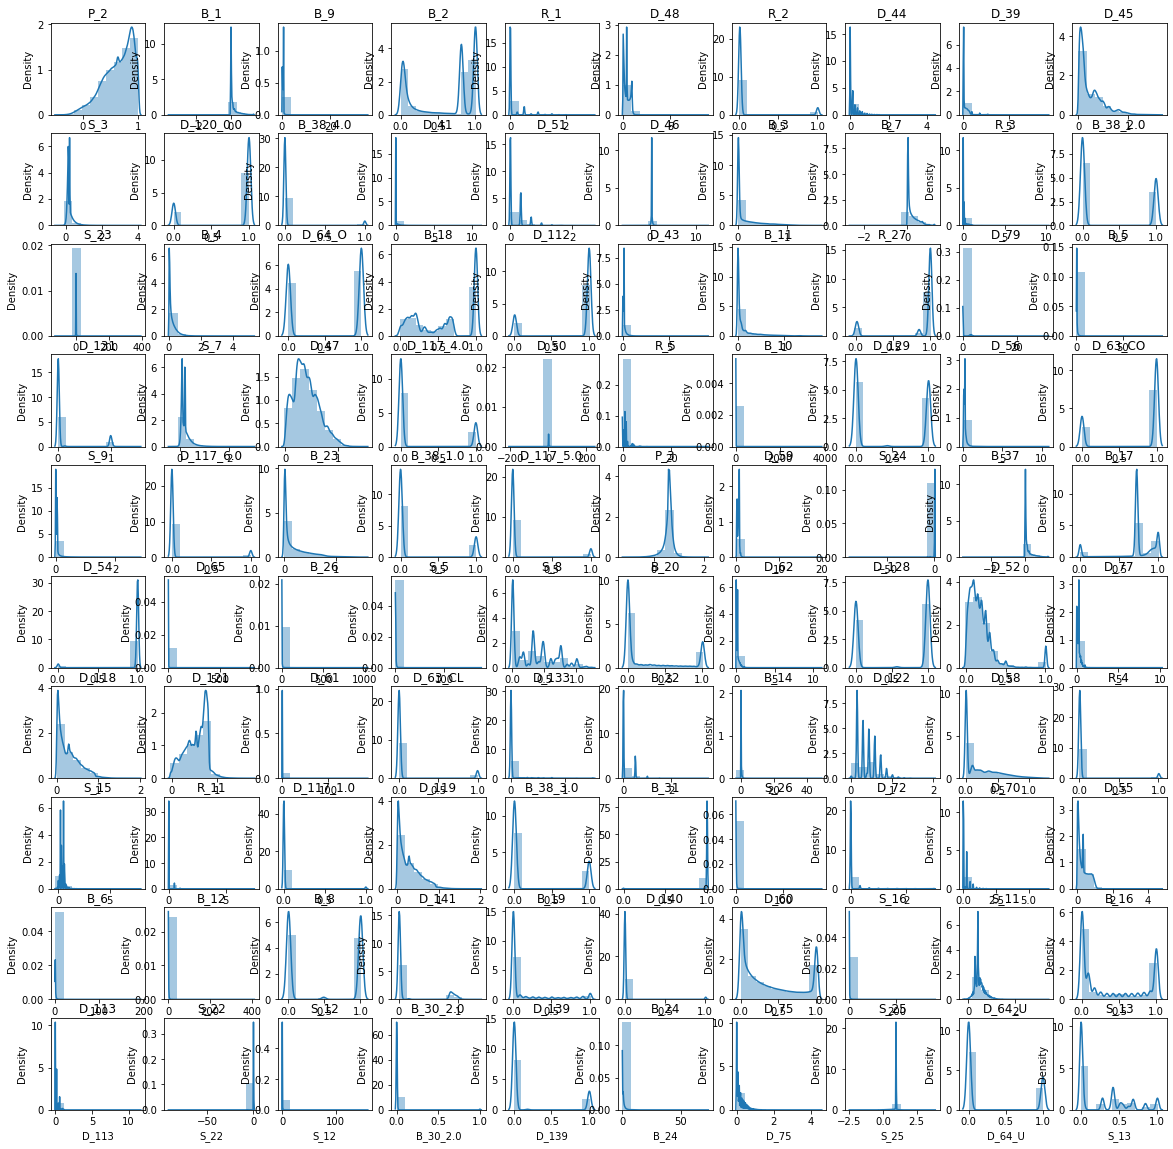

In [79]:
fig = plt.figure()
fig.set_size_inches(20, 20)

ax = []
for i, col_name in enumerate(df_all_new_onehot_impo.columns):
    ax.append(fig.add_subplot(10,10, i+1))
    x = df_all_new_onehot_impo[col_name]
    
    ax[i] = sns.distplot(x, bins = 10)
    ax[i].set_title(col_name)

- skewness checking

In [75]:
def skewness_level(x):
    if np.abs(x) > 1:
        return "high"
    elif -0.5 <= x <= 0.5:
        return "symmetrical"
    else:
        return "moderate"

In [77]:
skewness = df_all_new_onehot_impo.agg(["skew"]).T
skewness["skewness_level"] = skewness["skew"].apply(lambda x :skewness_level(x))
skewness

,skew,skewness_level
P_2,-0.736652,moderate
B_1,2.481290,high
B_9,8.038797,high
B_2,-0.426964,symmetrical
R_1,3.328665,high
...,...,...
B_24,22.146908,high
D_75,2.263438,high
S_25,-5.503861,high
D_64_U,1.029238,high


In [176]:
df_all_new_onehot_impo_skew = df_all_new_onehot_impo.copy()
skewness_variables = skewness[skewness['skewness_level'] == 'high'].index.tolist()

temp_feat = pd.DataFrame(df_all_new_onehot_impo[skewness_variables].min(axis = 0))
skewness_variables = temp_feat[temp_feat[0] > 0].index

for col in skewness_variables:
  df_all_new_onehot_impo_skew[col] = np.log(df_all_new_onehot_impo_skew[col])

skewness["log_transform_skewness_level"] = df_all_new_onehot_impo_skew.skew().T
skewness["log_transform_skewness_level"] = skewness["log_transform_skewness_level"].apply(lambda x :skewness_level(x))
skewness

,skew,skewness_level,log_transform_skewness_level
P_2,-0.736652,moderate,moderate
B_1,2.481290,high,high
B_9,8.038797,high,symmetrical
B_2,-0.426964,symmetrical,symmetrical
R_1,3.328665,high,moderate
...,...,...,...
B_24,22.146908,high,high
D_75,2.263438,high,moderate
S_25,-5.503861,high,high
D_64_U,1.029238,high,high


In [81]:
from collections import Counter

In [177]:
print('========before========')
print('symmetrical : ' + str(Counter(skewness["skewness_level"])['symmetrical']))
print('moderate : ' + str(Counter(skewness["skewness_level"])['moderate']))
print('high : ' + str(Counter(skewness["skewness_level"])['high']))
print('========after========')
print('symmetrical : ' + str(Counter(skewness["log_transform_skewness_level"])['symmetrical']))
print('moderate : ' + str(Counter(skewness["log_transform_skewness_level"])['moderate']))
print('high : ' + str(Counter(skewness["log_transform_skewness_level"])['high']))

========before========
symmetrical : 7
moderate : 10
high : 83
========after========
symmetrical : 23
moderate : 23
high : 54


In [186]:
X = df_all_new_onehot_impo_skew[:df_train_length]
y = df_train_target["target"]

# Train Test Split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

random_parameters = {'max_depth':[7,8,9],
                      'min_child_weight': [5,6,7,8],
                      'eta':[.1, .01],
                      'objective':['binary:logistic'],
                      'tree_method': ['gpu_hist'],
                      'eval_metric': ['rmsle'],
                      'predictor': ['gpu_predictor']
}

XGB_Best = XGBoost_Randomize_CV(train_X,train_y, random_parameters)

# Validation
pred = XGB_Best.predict(test_X).round().astype(int)
amex_actual = pd.DataFrame({'target':test_y}).reset_index(drop=True)
amex_prediction = pd.DataFrame({'prediction':XGB_Best.predict_proba(test_X)[:, 1]}).reset_index(drop=True)

print('Accuracy:', accuracy_score(test_y, pred))
print('Log Loss:', log_loss(test_y, pred))
print('ROC Accuracy:', roc_auc_score(test_y, pred))
print('Confusion Matrix:\n', 
       confusion_matrix(test_y, pred))
print('Amex Metric:', amex_metric(amex_actual,amex_prediction))

{'max_depth': 7, 'min_child_weight': 5, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7771029316084517
{'max_depth': 7, 'min_child_weight': 5, 'eta': 0.01, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7471049253376298
{'max_depth': 7, 'min_child_weight': 6, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7778602590058892
{'max_depth': 7, 'min_child_weight': 6, 'eta': 0.01, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7465010717605994
{'max_depth': 7, 'min_child_weight': 7, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle', 'predictor': 'gpu_predictor'}: 0.7762040347260989
{'max_depth': 7, 'min_child_weight': 7, 'eta': 0.01, 'objective': 'binary

In [187]:
test_X = df_all_new_onehot_impo_skew[df_train_length:]
XGB_pred = XGB_Best.predict(test_X)
submission = pd.DataFrame(customerID)[df_train_length:]
submission['prediction'] = XGB_pred
submission.to_csv('submission5.csv', index=False)